Muon constants <br>
https://pdglive.lbl.gov/Particle.action?node=S004&init=0

# Theory of Muon Magnetic Moment Determination

## Experimental Setup

**Components:**
- **Cosmic Ray Muons:** Source particles from atmospheric interactions
- **Trigger Detector:** Identifies muon arrival
- **Solenoid:** Generates uniform magnetic field (B ≈ 5.6 mT)
- **Absorber:** Dense material block where muons decay
- **Positron Detector:** Detects decay products

## Physics Principles

### Without Magnetic Field
Simple exponential decay:
$$N(t) = N_0 e^{-t/\tau_\mu}$$

Muon lifetime: $\tau_\mu = 2.1969811 \pm 0.0000022$ μs

### With Magnetic Field
Muon spin precesses with frequency:
$$\omega = g_\mu \frac{eB}{2m_\mu c}$$

Time-dependent signal with oscillation:
$$N(t) = N_0 e^{-t/\tau_\mu}[1 + A \cos(\omega t + \phi)]$$

### Decay Process
$$\mu^+ \rightarrow e^+ + \nu_e + \bar{\nu}_\mu$$
$$\mu^- \rightarrow e^- + \bar{\nu}_e + \nu_\mu$$

## Analysis Method
**MCMC fitting:**
- **B = 0:** Extract $\tau_\mu$ from exponential decay
- **B ≠ 0:** Extract $\omega$ from oscillating signal
- Determine $g_\mu$ from measured precession frequency

# SIMULATED DATA

In [1]:
G.mean  <- 2.00233184123 # pure number
G.sigma <- 0.00000000014 # pure number

TAU.mean  <- 2.1969811  # microseconds
TAU.sigma <- 0.0000022  # microseconds

B.mean  <- 5.6e-3  # Tesla
B.sigma <- 0.1e-3  # Tesla

MASS.mean  <- 105.6583755e6 # ev/c^2
MASS.sigma <-   0.0000023e6 # Mv/c^2

c <- 299792458 # m/s
e <- 1.60217663e-19 # Coulomb

MASS.kg <- MASS.mean*e / c^2  # kg

OMEGA <- (G.mean*e*B.mean) / (2*MASS.kg*c) # rad/s

cat("Omega is: ",OMEGA,"rad/s. \n")

Omega is:  0.01590783 rad/s. 


In [2]:
N0  <- 1e3 # number initial muons
A   <- 0.3 # % polarized muons
phi <- 0.5   # initial phase

In [3]:
dt <-0.1
t <- seq(dt/2,15,dt) # microseconds
#Effeciency.Detector <- 0.8 # to introduce randomness even in the time component
#mask <- sample(c(TRUE, FALSE), size=length(t), replace=TRUE, prob=c(Effeciency.Detector,1-Effeciency.Detector))
#t <- t[mask]

N.noB.ideal <- N0 * exp(-t/TAU.mean)

N.withB.ideal <- N0 * exp(-t/TAU.mean) * (1 + A*cos(OMEGA*t+phi))

GenerateData <- function(t,N.ideal,show=FALSE) {

    set.seed(as.integer((as.numeric(Sys.time()) %% 1) * 1e8)) #uso il tempo del pc per generare un numero casuale

    sigma <- sqrt( N.ideal * ( 1-N.ideal/sum(N.ideal) ) ) |> round(,0)
    sigma <- pmax(sigma,1) |> as.integer()

    # VARI TENTATIVI
    #N <- rpois(length(t), N.ideal) # simulated measurements
    #noise <- rnorm( length(t), mean=0, sd=sqrt(N.ideal) ) # simulated background noise
    #N <- (N + noise)
    #N <- N * runif(length(t),0.8,1.2) |> round(,0) |> as.integer()

    N <- rnorm( length(t),N.ideal,sigma ) |> round(,0)
    N <- pmax( N,0 ) |> as.integer()
        
    data <- data.frame(t=t, y=N, s=sigma)
    if (show) { print( head(data,5) ); cat("\n") ; print( tail(data,5) ) ; cat("\n") }

    return(data)
    }

In [4]:
plot.data <- function(data,title) {
    options(repr.plot.width=16,repr.plot.heigth=8)
    
    par(mfrow=c(1,2))
    
    # normal scale
    plot(data$t, data$y, type="p", pch=16, col="red",
         xlab=expression("Time ["*mu*"s]"), ylab="Counts", main=title,
         cex.main=1.5, cex.axis=1.5, cex.lab=1.5)

    arrows(data$t, data$y-data$s, data$t, data$y+data$s,
           angle=90, code=3, length=0.02, col="lightblue")
    
    # log scale
    plot(data$t, pmax(data$y,1), log="y", yaxt="n", type="p", pch=16, col="blue",
         xlab=expression("Time ["*mu*"s]"), ylab="Counts", main=title,
         cex.main=1.5, cex.axis=1.5, cex.lab=1.5)
    
    arrows(data$t, data$y-data$s, data$t, data$y+data$s,
           angle=90, code=3, length=0.02, col="lightblue")

    axis(2, at=10^(0:5), labels=parse(text=paste0("10^", 0:5)), las=1)

    }

In [5]:
data.noB   <- GenerateData(t,N.noB.ideal,show=TRUE)

     t    y  s
1 0.05 1005 31
2 0.15  921 30
3 0.25  903 29
4 0.35  820 29
5 0.45  801 28

        t y s
146 14.55 2 1
147 14.65 2 1
148 14.75 2 1
149 14.85 1 1
150 14.95 1 1



In [6]:
data.withB <- GenerateData(t,N.withB.ideal,show=TRUE)

     t    y  s
1 0.05 1170 34
2 0.15 1171 34
3 0.25 1159 33
4 0.35 1115 32
5 0.45 1019 31

        t y s
146 14.55 2 1
147 14.65 2 1
148 14.75 0 1
149 14.85 1 1
150 14.95 2 1



In [7]:
data <- list(data.noB,data.withB)

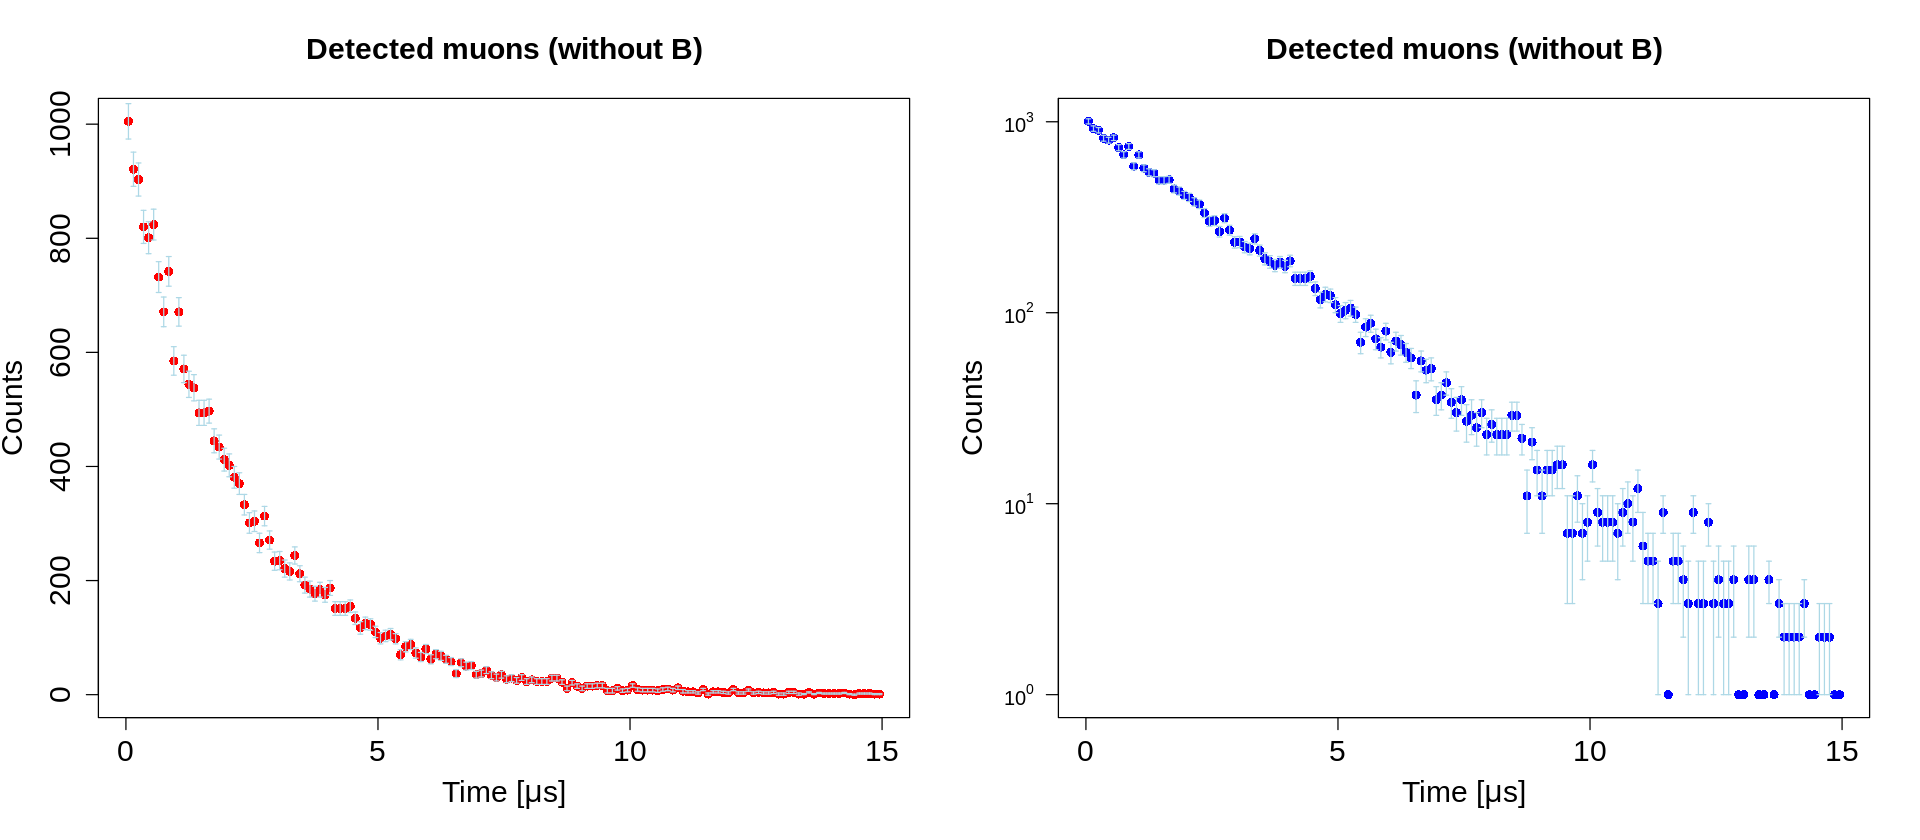

In [8]:
plot.data(data.noB,"Detected muons (without B)")

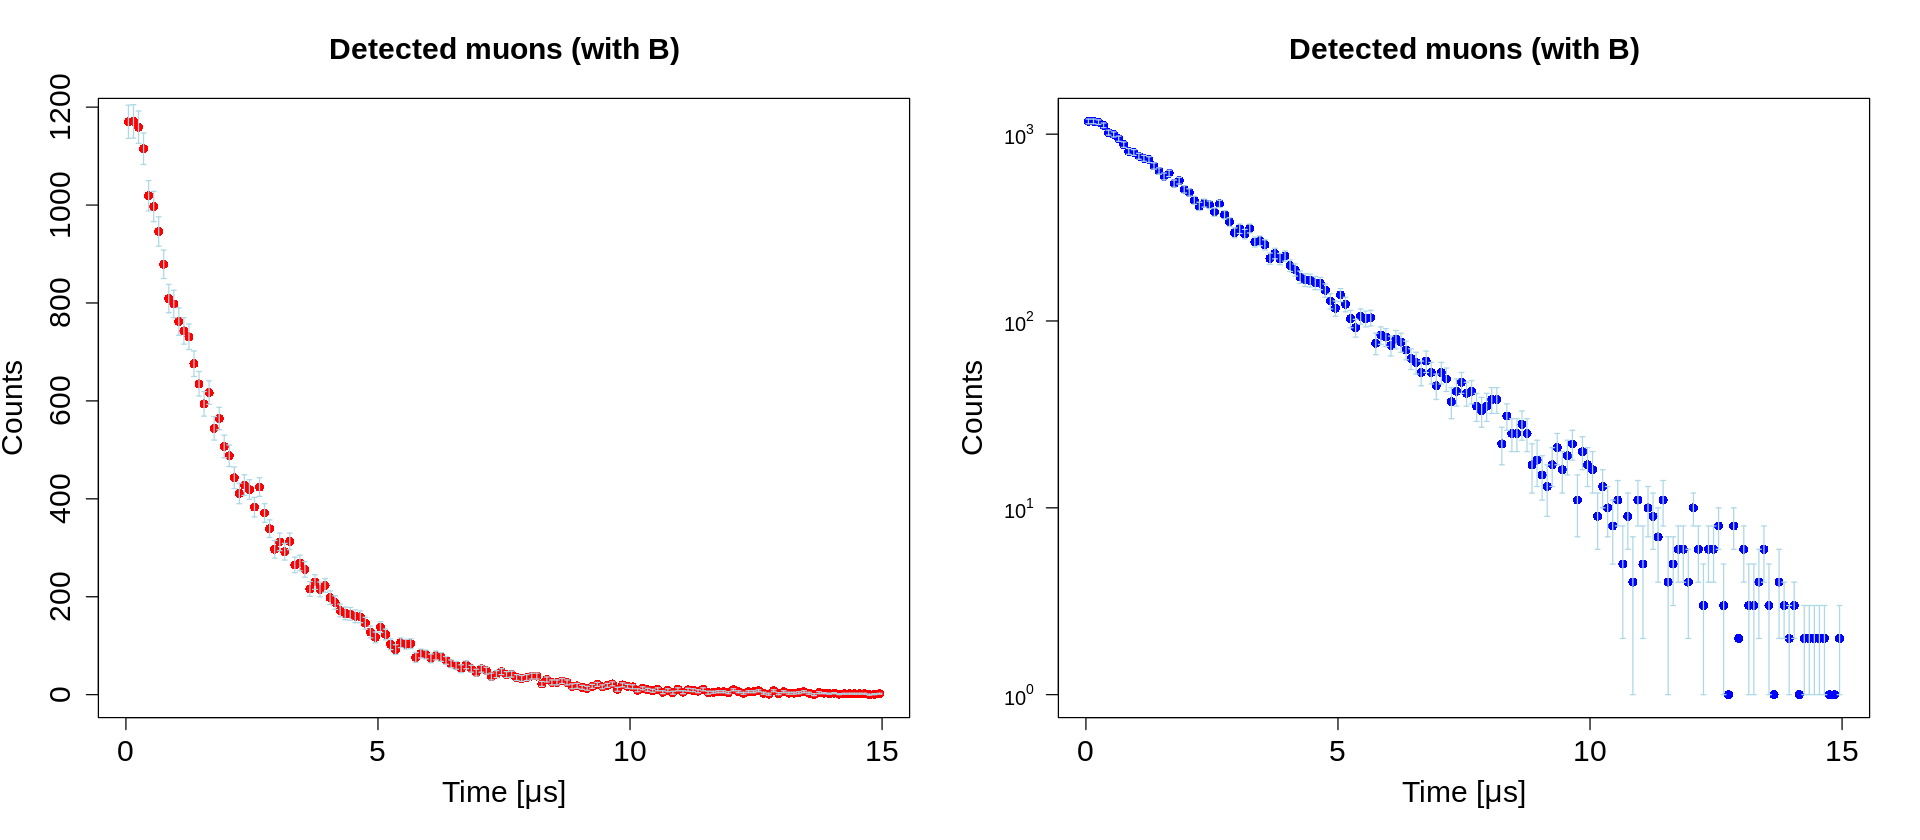

In [9]:
plot.data(data.withB,"Detected muons (with B)")

# MCMC ANALYSIS

In [10]:
library("rstan")
options (mc.cores=parallel::detectCores())
rstan_options (auto_write=TRUE)
library("coda")

Warning message:
“il pacchetto ‘rstan’ è stato creato con R versione 4.3.3”
Caricamento del pacchetto richiesto: StanHeaders

Warning message:
“il pacchetto ‘StanHeaders’ è stato creato con R versione 4.3.3”

rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)


Warning message:
“il pacchetto ‘coda’ è stato creato con R versione 4.3.3”

Caricamento pacchetto: ‘coda’


Il seguente oggetto è mascherato da ‘package:rstan’:

    traceplot




In [11]:
# varsatile way, so we can change model since evry time copy & paste

data.model.stan <- "data {
        int<lower=0> n;
        vector[n] t;
        vector<lower=0>[n] y;
        vector<lower=0>[n] s;
}\n"

parameters <- c(
    noB = "parameters {
        real<lower=0> N0;
        real<lower=0> tau;
    }\n",
    withB = "parameters {
        real<lower=0> N0;
        real<lower=0> tau;
        real<lower=0, upper=1> A;
        real<lower=0> omega;
        real<lower=0, upper=2*pi()> phi;
    }\n"   
)

model <- c(
    noB = "model {
        N0 ~ normal(y[1],sqrt(y[1])) ;
        tau ~ normal(2.2,0.1) ;
        for (i in 1:n) { y[i] ~ normal( N0*exp(-t[i]/tau), s[i] ); }
    }\n",
    withB = "model {
        N0 ~ normal(y[1],sqrt(y[1])) ;
        tau ~ normal(2.2,0.1) ;
        A ~ uniform(0,0.5) ;
        omega ~ uniform(0,1) ; # ATTENZIONE ALLE UNITA' DI MISURA
        phi ~ uniform(0,2*pi()) ;
        for (i in 1:n) { y[i] ~ normal( N0*exp(-t[i]/tau)*(1+A*cos(omega*t[i]+phi)), s[i] ); }
    }\n"
)


stan.string <- c(noB = paste0(data.model.stan,parameters[1],model[1]), withB = paste0(data.model.stan,parameters[2],model[2]))
#cat( stan.string[[2]] )

#data.stan = c( list( n=length(t), t=data[1]$t, y=data[1]$y, s=data[1]$s ) , list( n=length(t), t=data[2]$t, y=data[2]$y, s=data[2]$s )  )
data.stan = lapply( 1:2, function(i) { list( n=length(t), t=data[[i]]$t, y=data[[i]]$y, s=data[[i]]$s ) } )

In [12]:
analysis.bayes <- function(stan.string, data.stan, which.model) {

stan <- stan.string[ which.model ]
data <- data.stan[[which.model]]
params <- switch( which.model, c("N0","tau") , c("N0","tau","A","omega","phi") )
stan.model <- stan_model( model_code = stan )

stan.fit <- sampling(stan.model, data, pars=params, iter=1000, chains=2, warmup=200, thin=1)

cat( switch( which.model, "WITHOUT B\n" , "WITH B\n" ) )
print(summary(stan.fit))
array <- as.array(stan.fit)
return(array)
}

In [14]:
array.mcmc <- analysis.bayes(stan.string, data.stan, which.model=2)


# come è fatto array.mcmc[ indice iterazione ,quale catena , parametro:No-tau-omega....]

Warning message:
“There were 122 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 1.12, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#tail-ess”


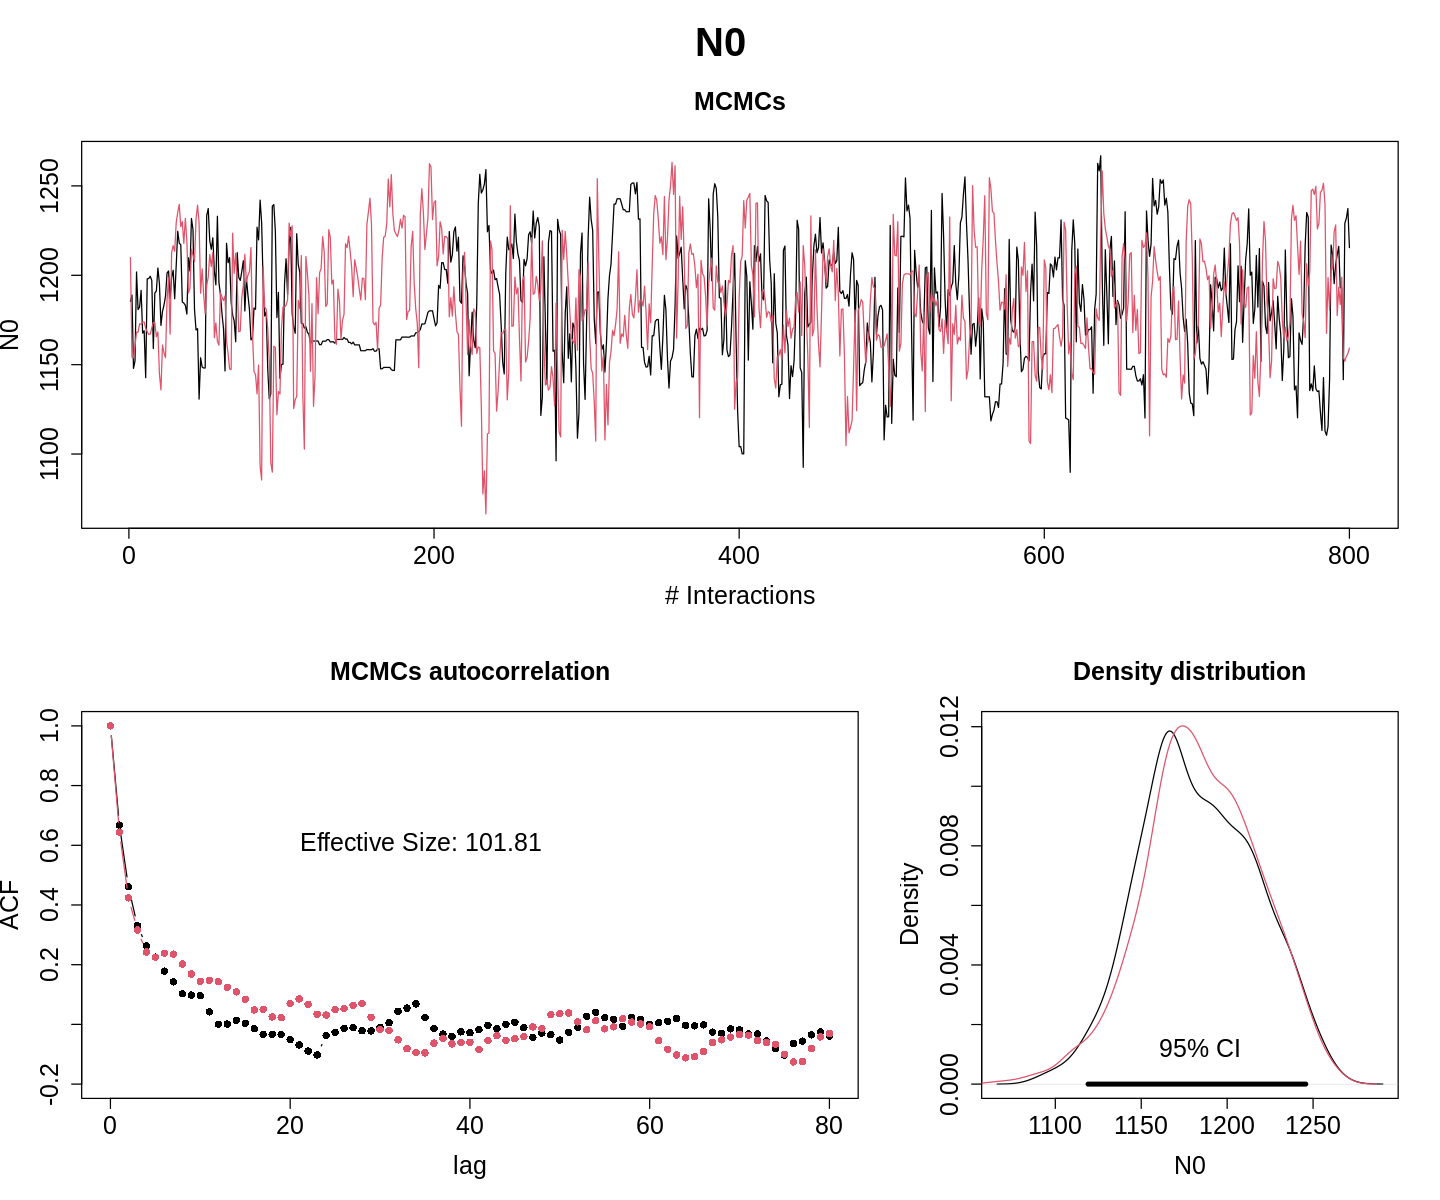

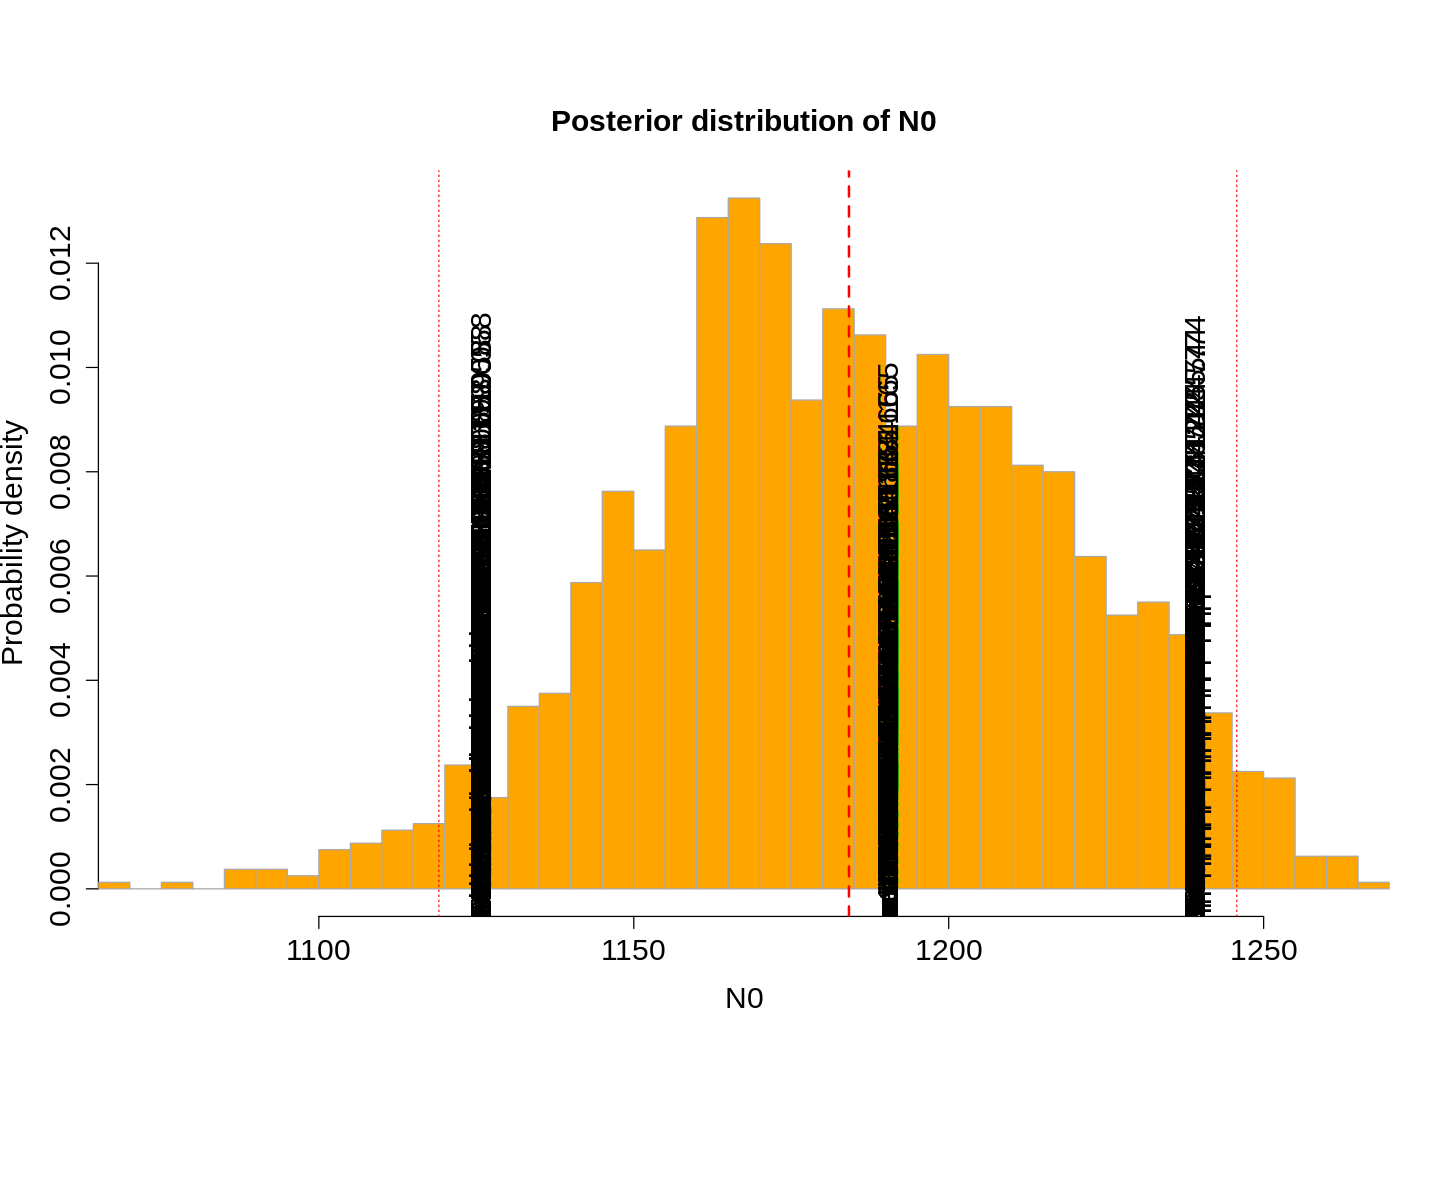

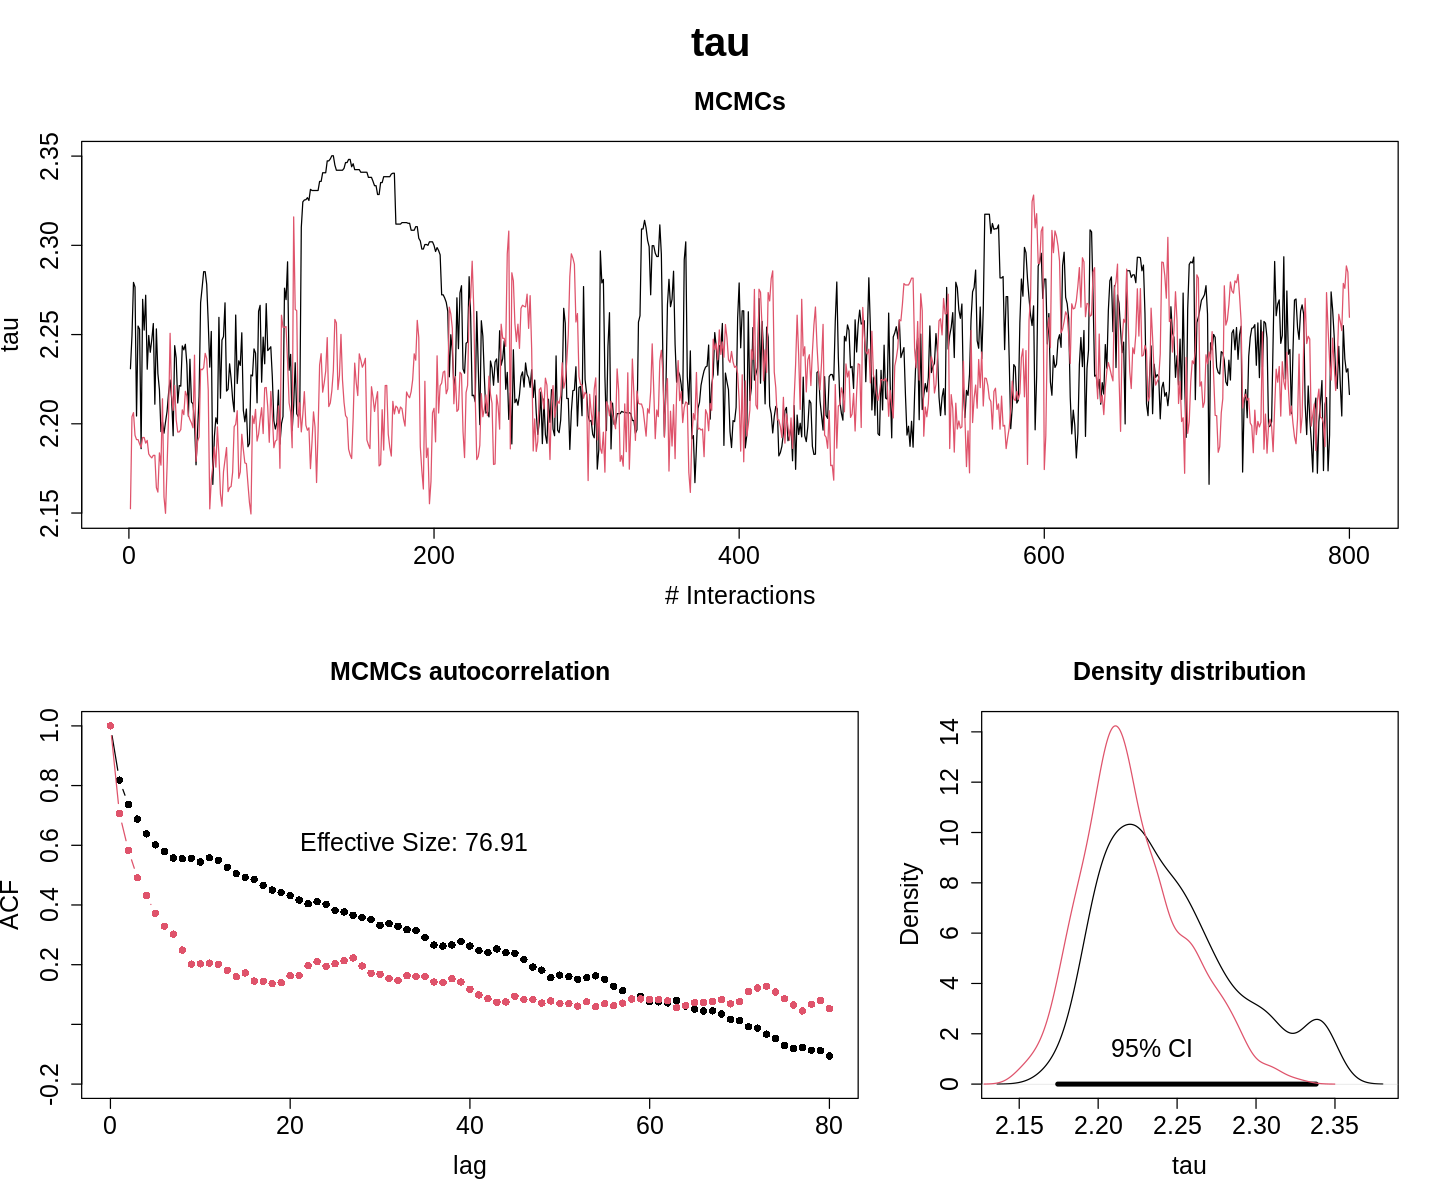

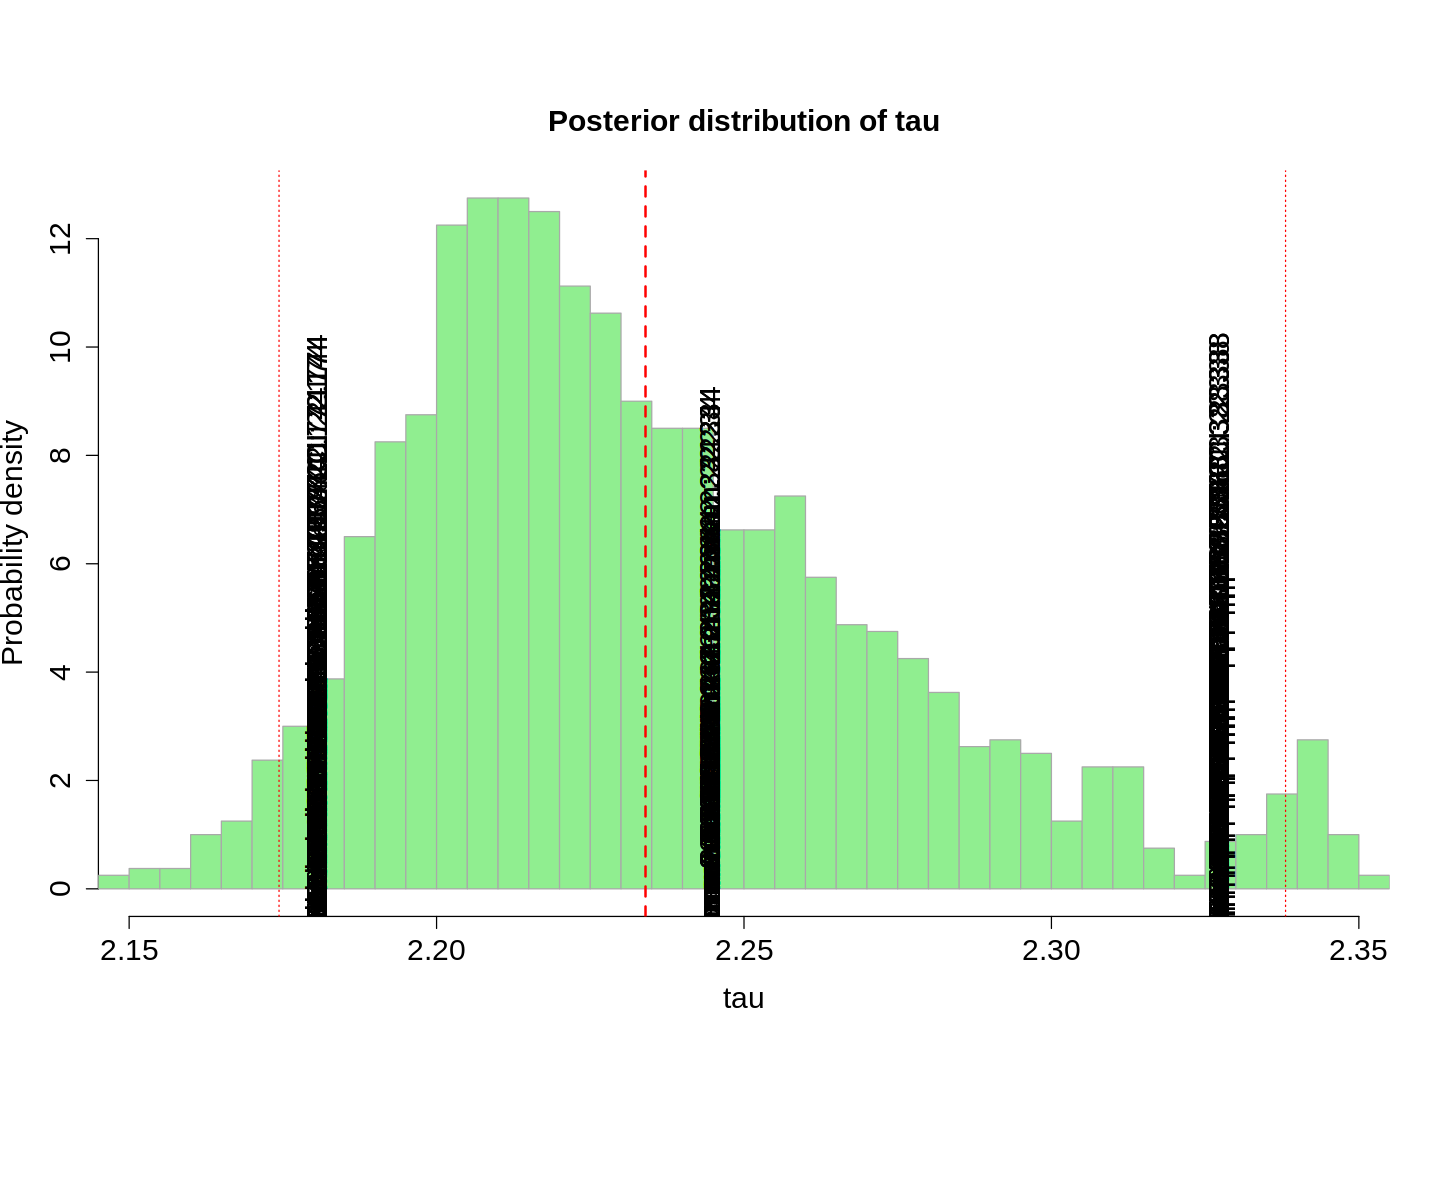

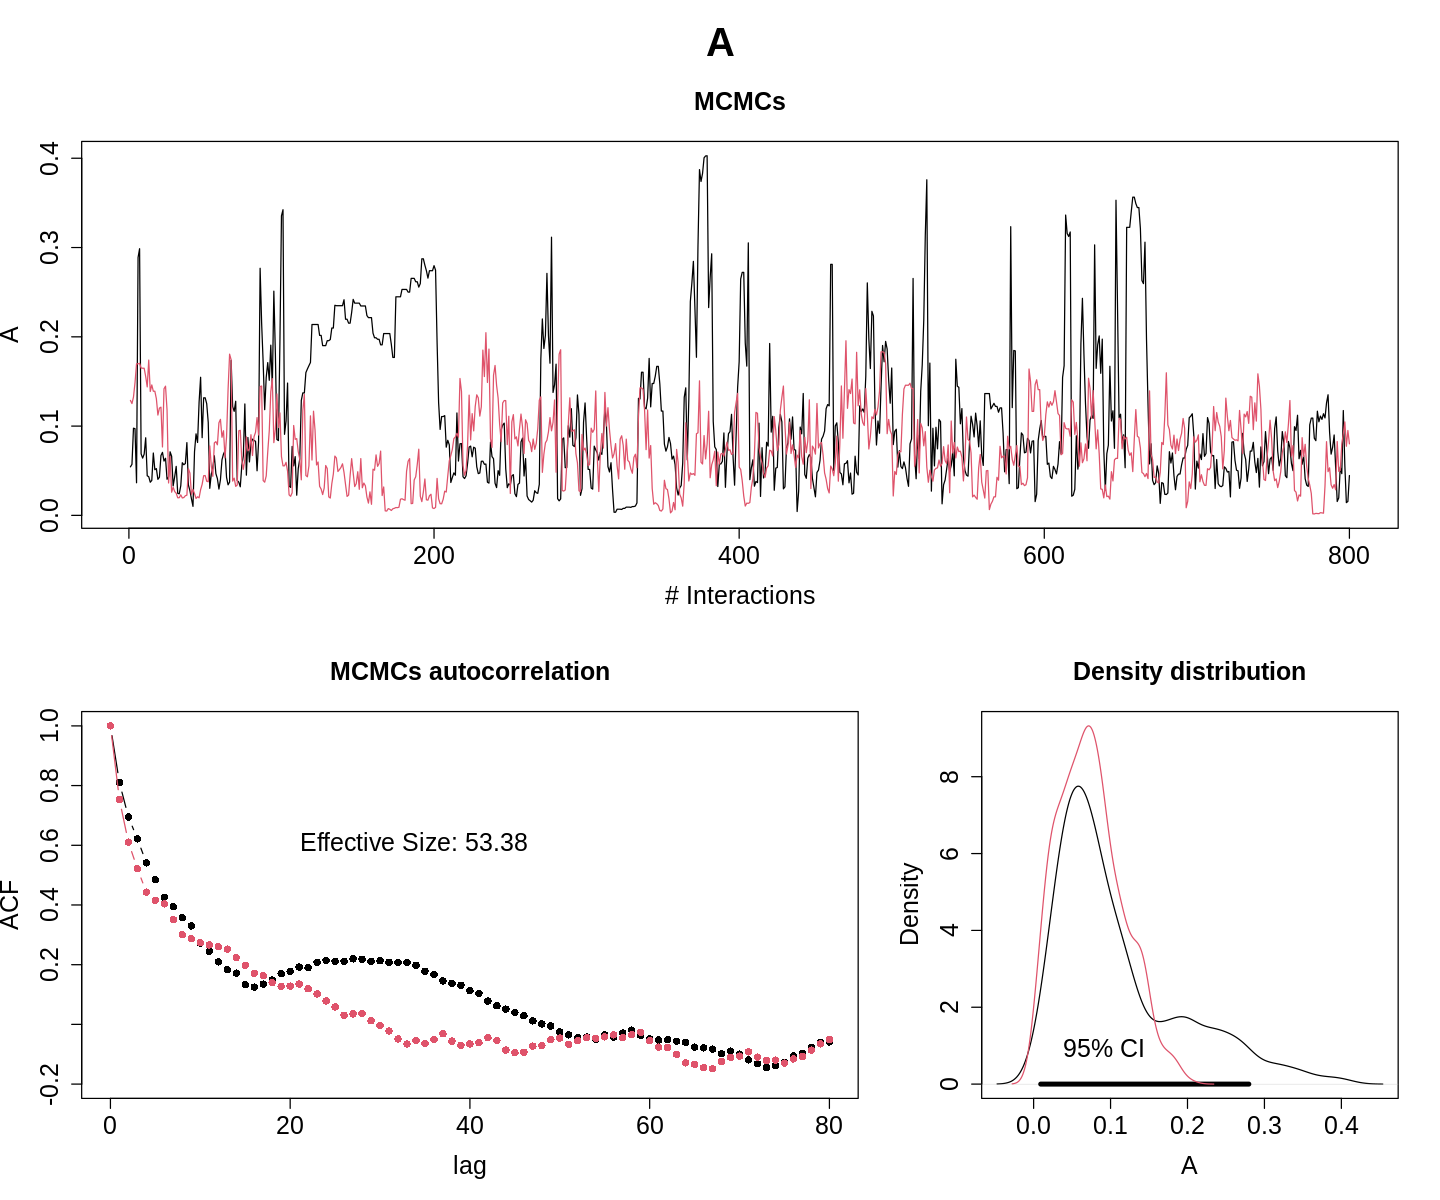

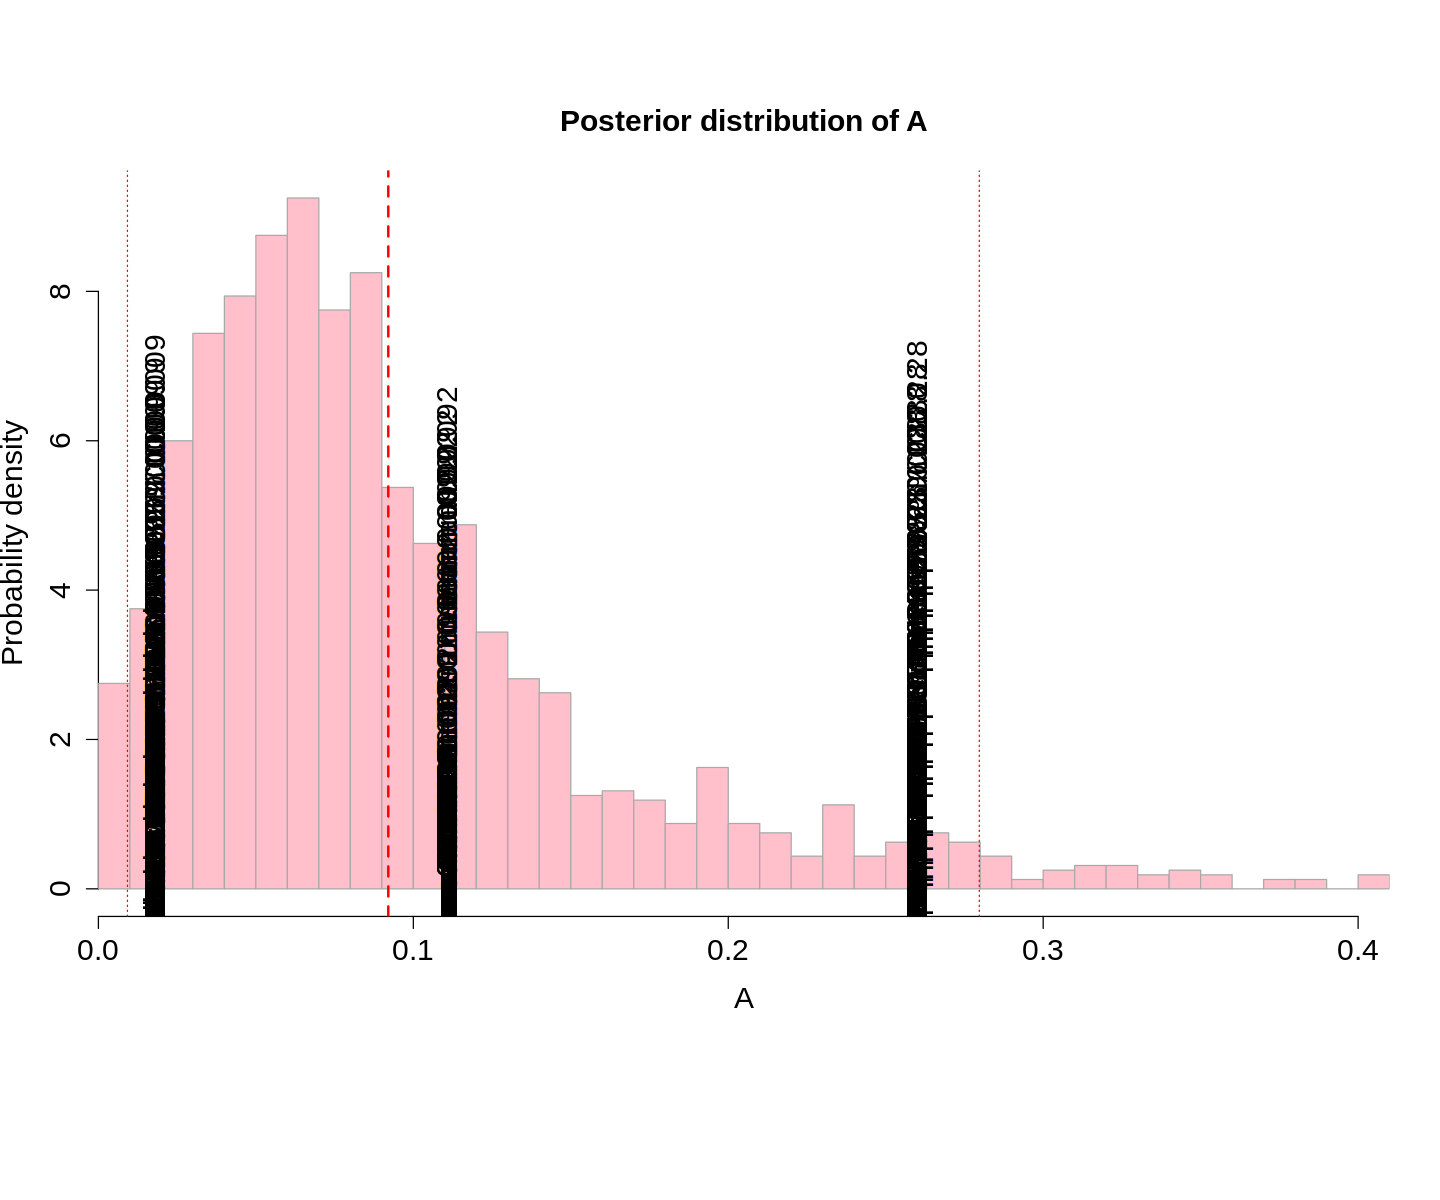

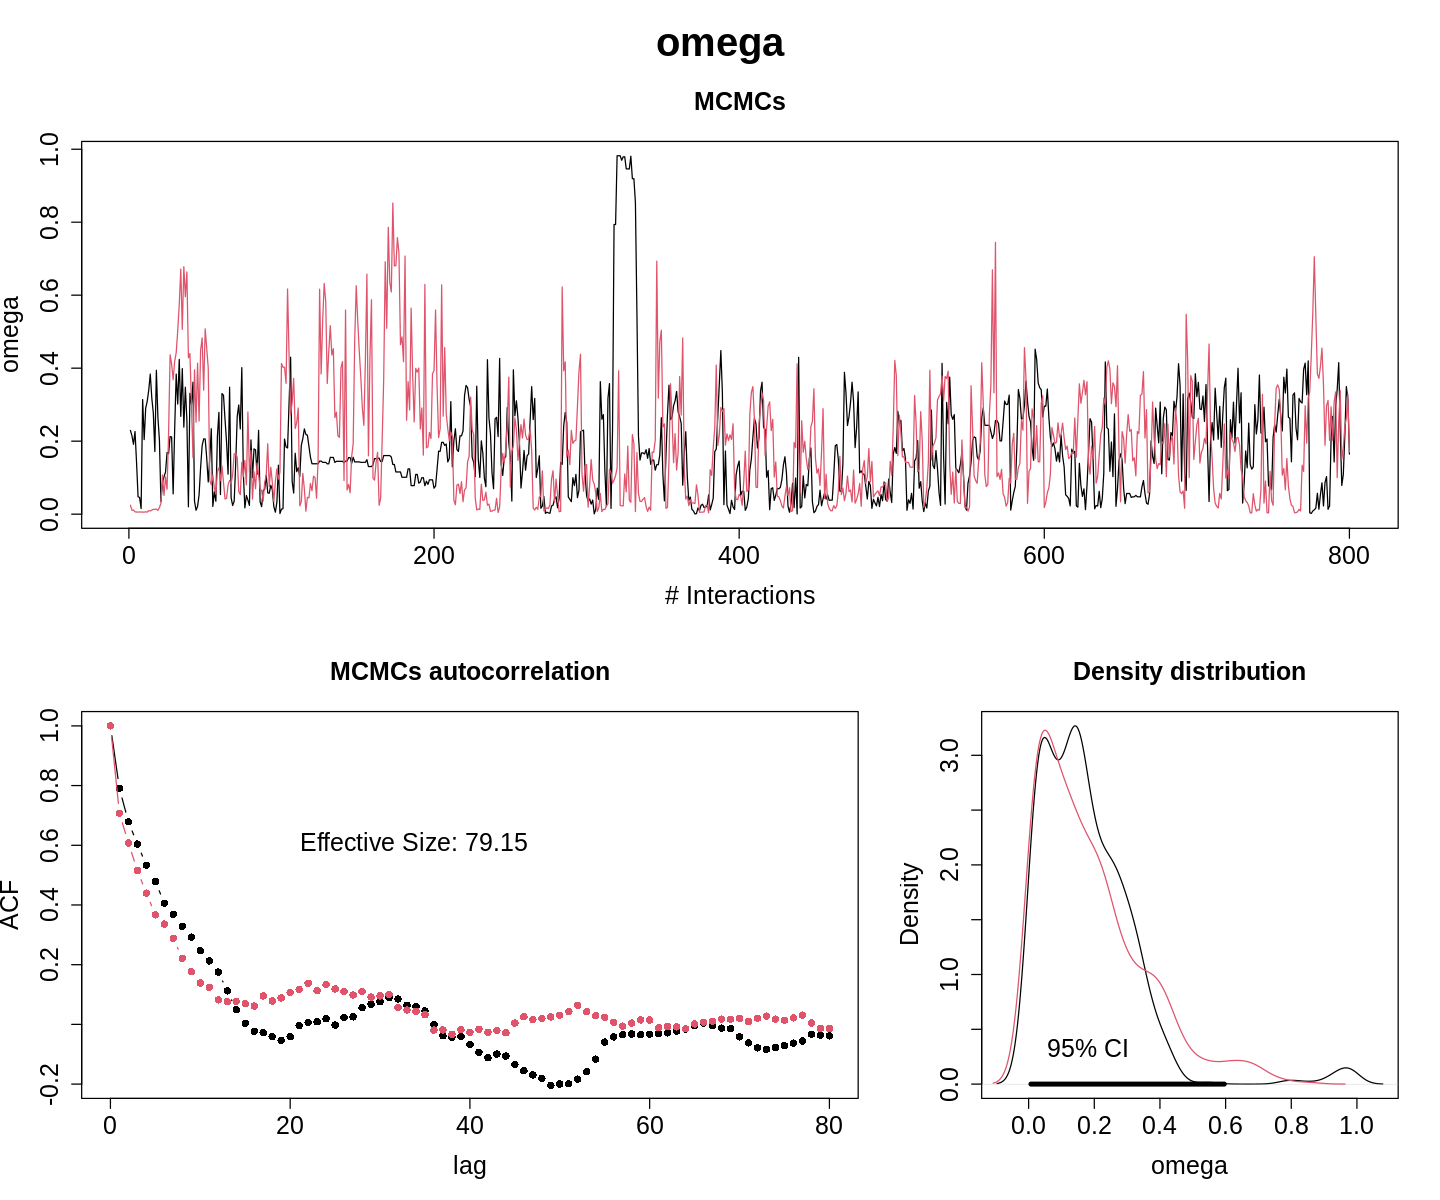

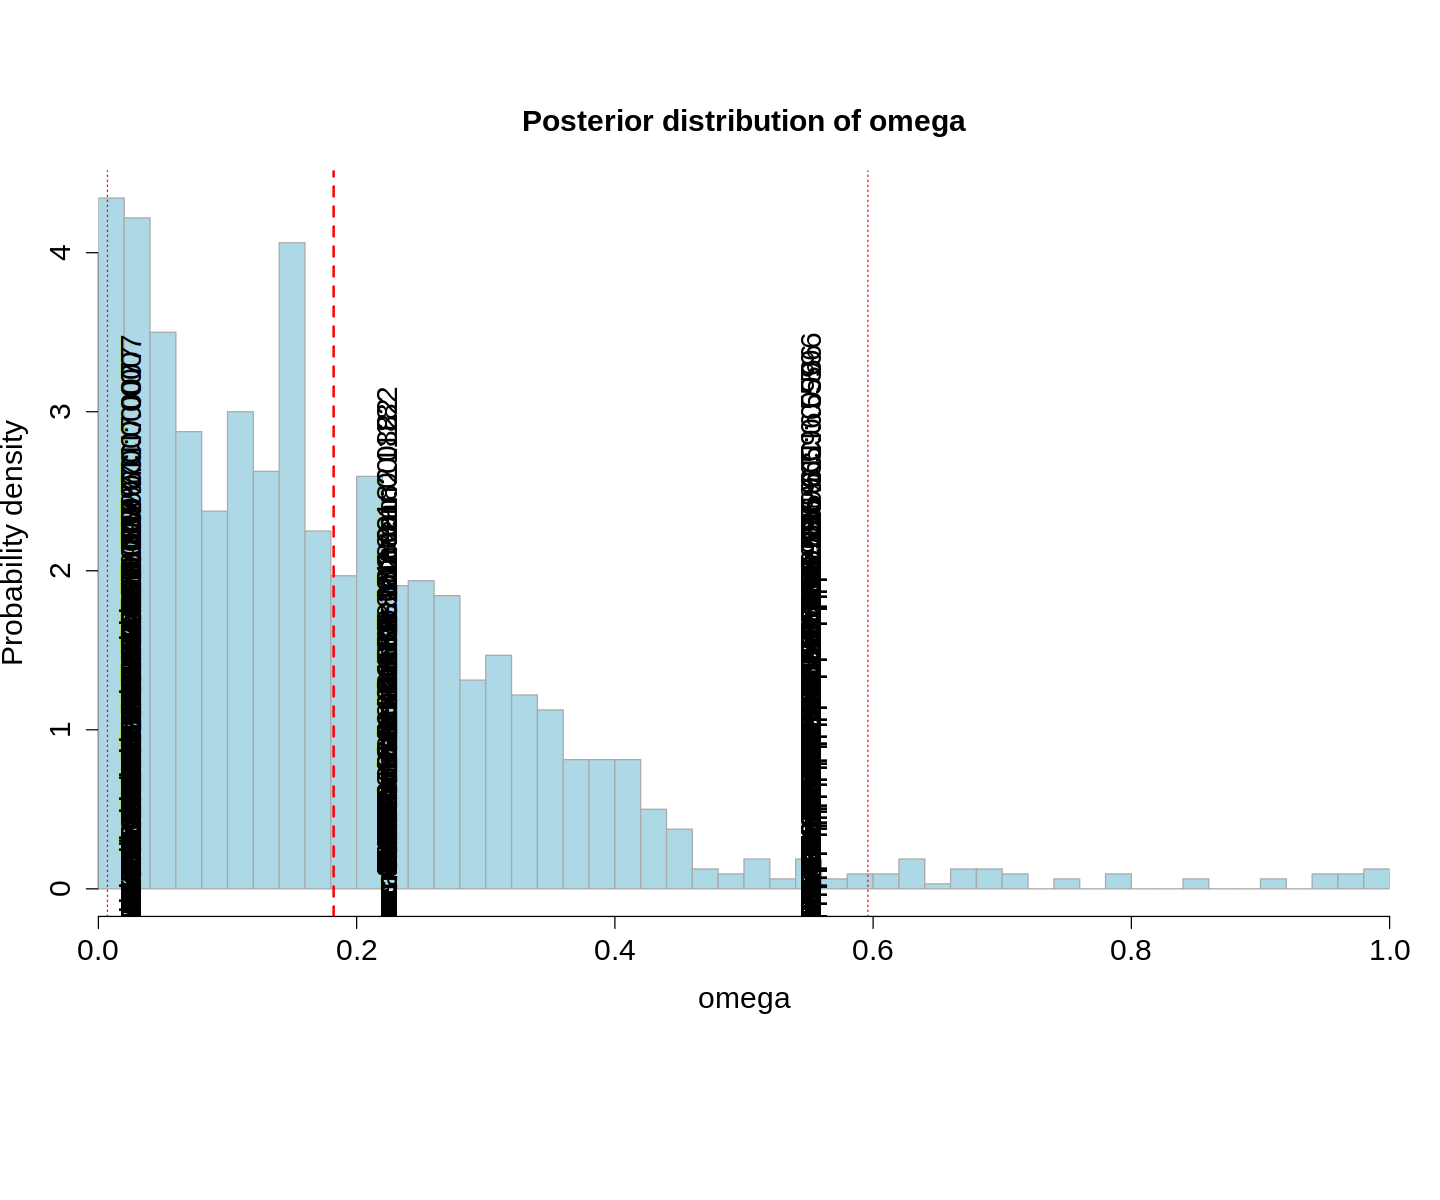

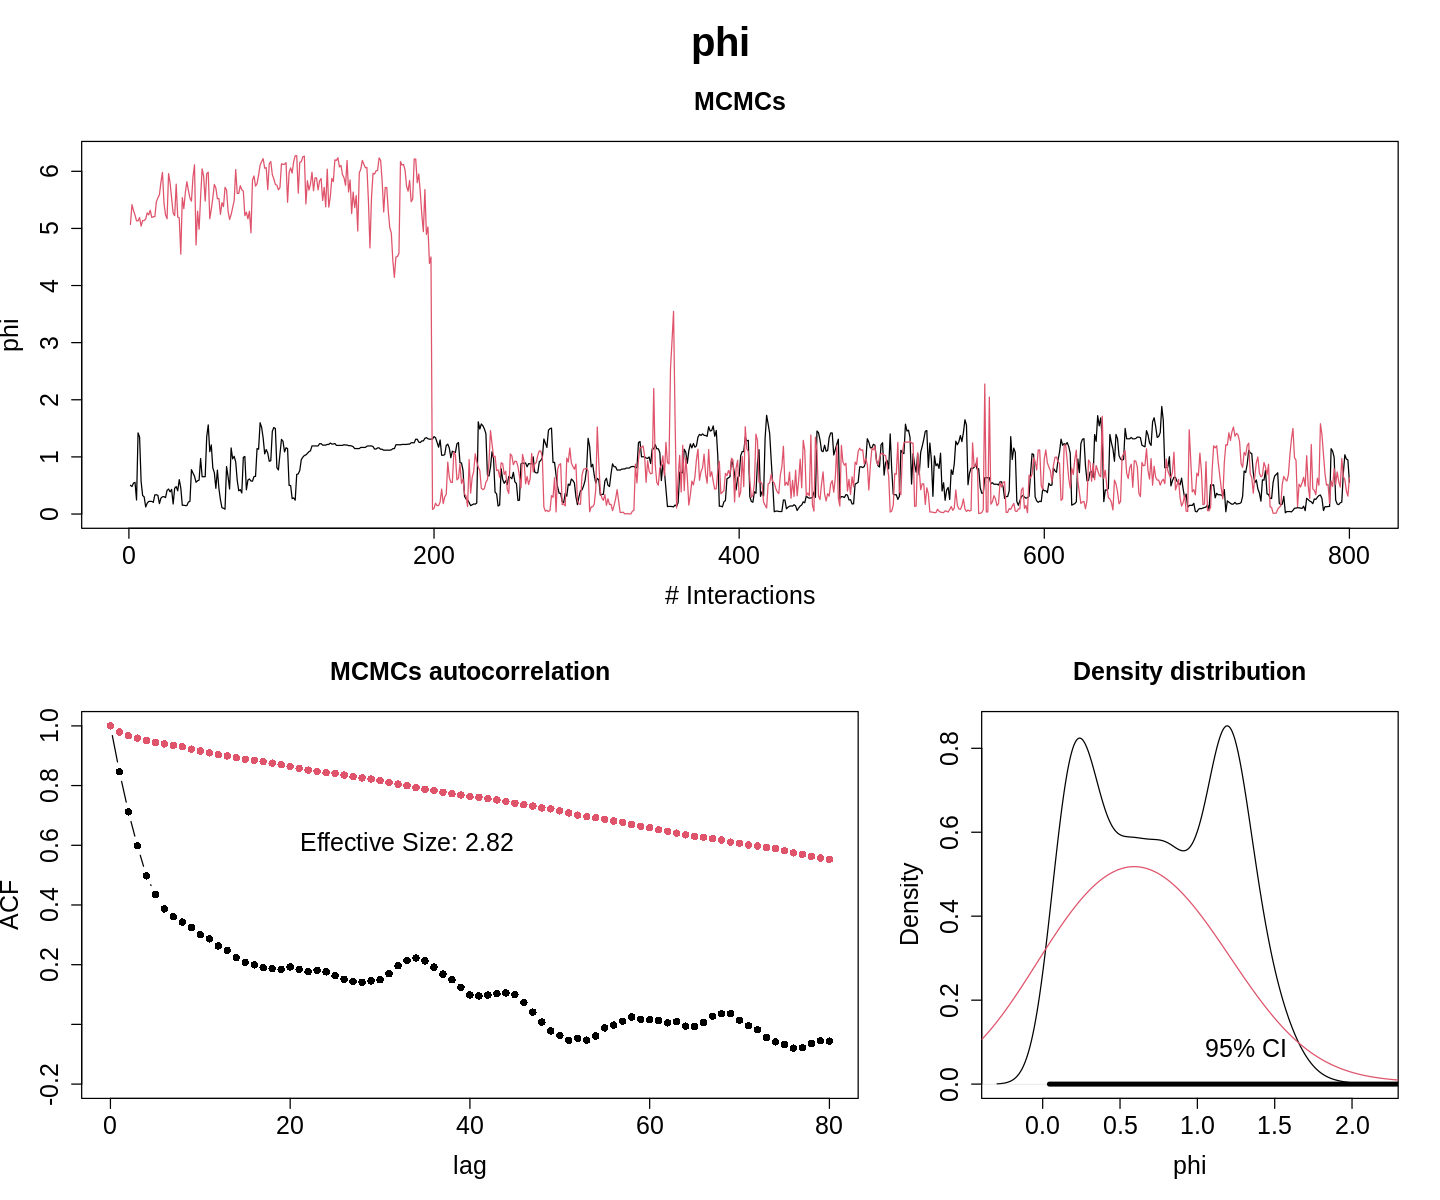

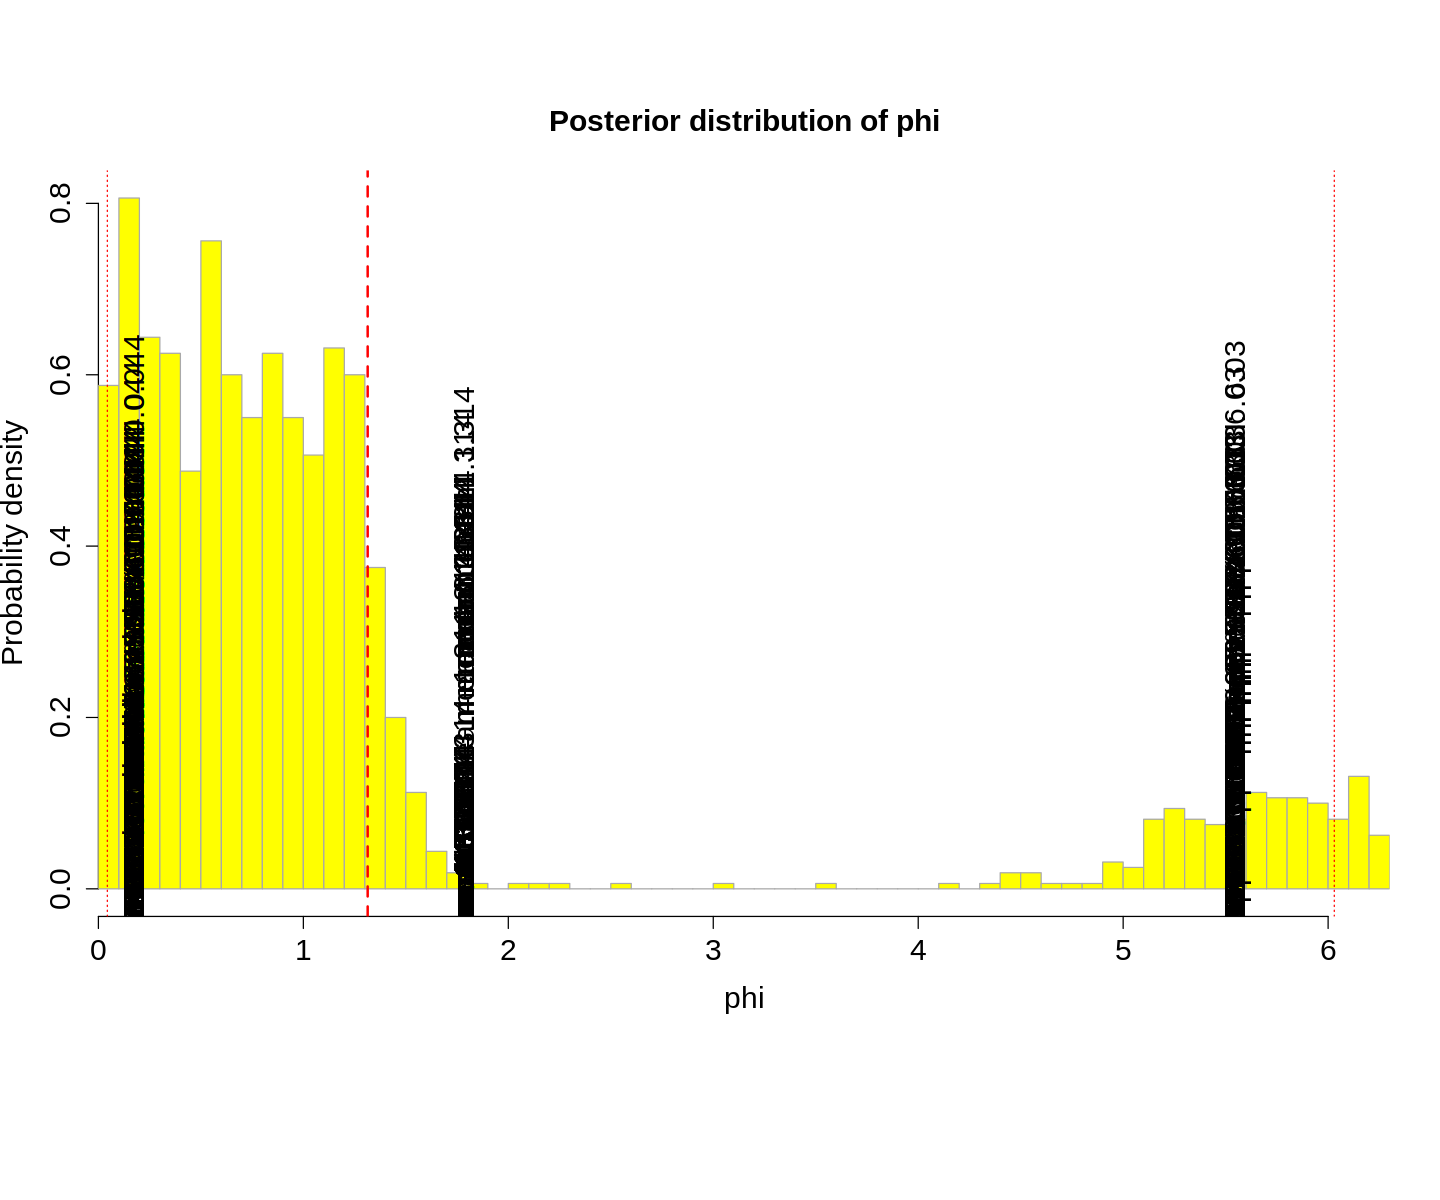

In [43]:
n.chains <- ncol(array.mcmc)
which.model <- 2
all.mcmc.coda <- mcmc.list( lapply (1:n.chains, function (x) { mcmc(array.mcmc[,x,]) })) # is a list of mcmc
params <- switch( which.model, c("N0","tau") , c("N0","tau","A","omega","phi") )
means <- numeric(length(params))

colors <- c("orange", "lightgreen", "pink", "lightblue", "yellow")

options(repr.plot.width=12, repr.plot.height=10)

# for cycle on all parameters
for(i in 1:length(params)) {

    par(mfrow=c(1, 1),oma=c(0,0,3,0))
    layout.matrix <- matrix(c(1, 2, 1, 3), nrow = 2, ncol = 2)
    layout(mat = layout.matrix,
       heights = c(1, 1), # Heights of the two rows
       widths = c(2.5, 1.5)) # Widths of the two columns
    
    # the chain interations
    for(j in 1:n.chains) {
        iteration.chain <- array.mcmc[,j,params[i]]
        max <- sapply( 1:n.chains, function(k) { max( array.mcmc[,k,params[i]] ) } ) |> max()
        min <- sapply( 1:n.chains, function(k) { min( array.mcmc[,k,params[i]] ) } ) |> min()
        
        if (j == 1) { plot( iteration.chain,type="l",col=j,cex.axis=1.5,cex.main=1.5,cex.lab=1.5,
                       main="MCMCs",ylab = params[i],xlab="# Interactions",ylim=c(min,max) ) }
        else {  lines(iteration.chain, col = j) }
    }
    
    mtext(params[i], outer=TRUE, cex=2, font=2)

    #autocorrelation
    my.lags <- 0:80
    for(j in 1:n.chains) {
        mcmc.coda <- all.mcmc.coda[[j]] # j-th chain
        acf <- autocorr(mcmc.coda[ ,params[i] ],lags=my.lags)
        if (j == 1) {
            plot(my.lags,acf,ylim=c(-0.2,1),type="b",pch=16,col=j,main="MCMCs autocorrelation",
            xlab="lag",ylab="ACF",cex.axis=1.5,cex.main=1.5,cex.lab=1.5)
        }
        else {
            lines(my.lags,acf,type="b", pch=16,col=j)
        }
    }
    text(20,0.6,paste( "Effective Size:",round(effectiveSize(mcmc.coda[,params[i]]),2)),pos=4,cex=1.5)

    all.data.param <- array.mcmc[,,params[i]]
    mean <- mean(all.data.param)
    means[i] <- mean
    CI <- quantile(all.data.param, c(0.025, 0.975))
    
    # density distribution
    for(j in 1:n.chains) {
        dens <- array.mcmc[,,params[i]]
        max <- sapply( 1:n.chains, function(k) { max(density(dens[,k])$y) } ) |> max()
        min <- sapply( 1:n.chains, function(k) { min(density(dens[,k])$y) } ) |> min()
        
        if (j == 1) { plot( density( dens[,j] ),main="Density distribution",
                           col=j,cex.axis=1.5,cex.main=1.5,cex.lab=1.5,xlab=params[i],
                           ylim=c(min,max) )
                    lines(c(CI[1],CI[2]),c(0,0),lwd=4)
                    text(mean, (max-min)*0.1, "95% CI",cex=1.5)
                    }
        else { lines( density(dens[,j]),col=j ) }
    }
  
    
    layout.matrix <- matrix(c(1,0), nrow=2, ncol=1)
    layout(mat = layout.matrix,
       heights = c(3,0.5),
       widths = c(2))
    
    # histrogram of distribution
    h <- hist(all.data.param,breaks=50,probability=TRUE,main=paste("Posterior distribution of",params[i]),
       xlab=params[i],ylab="Probability density",col=colors[i],border="darkgrey",xaxs="i",cex.axis=1.5,cex.main=1.5,cex.lab=1.5)    
    abline( v=mean, col="red", lwd=2, lty=2)

    h$density
    text(0.9*mean+0.1*CI[2],0.6*h$density, paste("mean: ",round(mean,3)), srt=90,cex=1.5)
    
    # 95% CI
    abline(v=CI, col="red", lwd=1, lty=3)
    text(0.9*CI[1]+0.1*mean,0.6*h$density,paste("lower 95% CI: ",round(CI[1],3)),cex=1.5,srt=90)
    text(0.9*CI[2]+0.1*mean,0.6*h$density,paste("upper 95% CI: ",round(CI[2],3)),cex=1.5,srt=90)
}

In [74]:
# combine sequentially all chains to get get one single dataframe for collelations
df <- lapply( params, function(p) { sapply(1:n.chains, function(j) array.mcmc[, j, p]) |> as.vector() } ) |> as.data.frame()
names(df) <- params
cat("Correlation matrix \n")
cor(df)

Correlation matrix 


,N0,tau,A,omega,phi
N0,1.0000000,-0.2820975,-0.51843030,0.3567370,0.10815694
tau,-0.2820975,1.0000000,0.40470114,0.1545401,-0.22044028
A,-0.5184303,0.4047011,1.00000000,-0.4572317,-0.03500444
omega,0.3567370,0.1545401,-0.45723172,1.0000000,0.11596417
phi,0.1081569,-0.2204403,-0.03500444,0.1159642,1.00000000


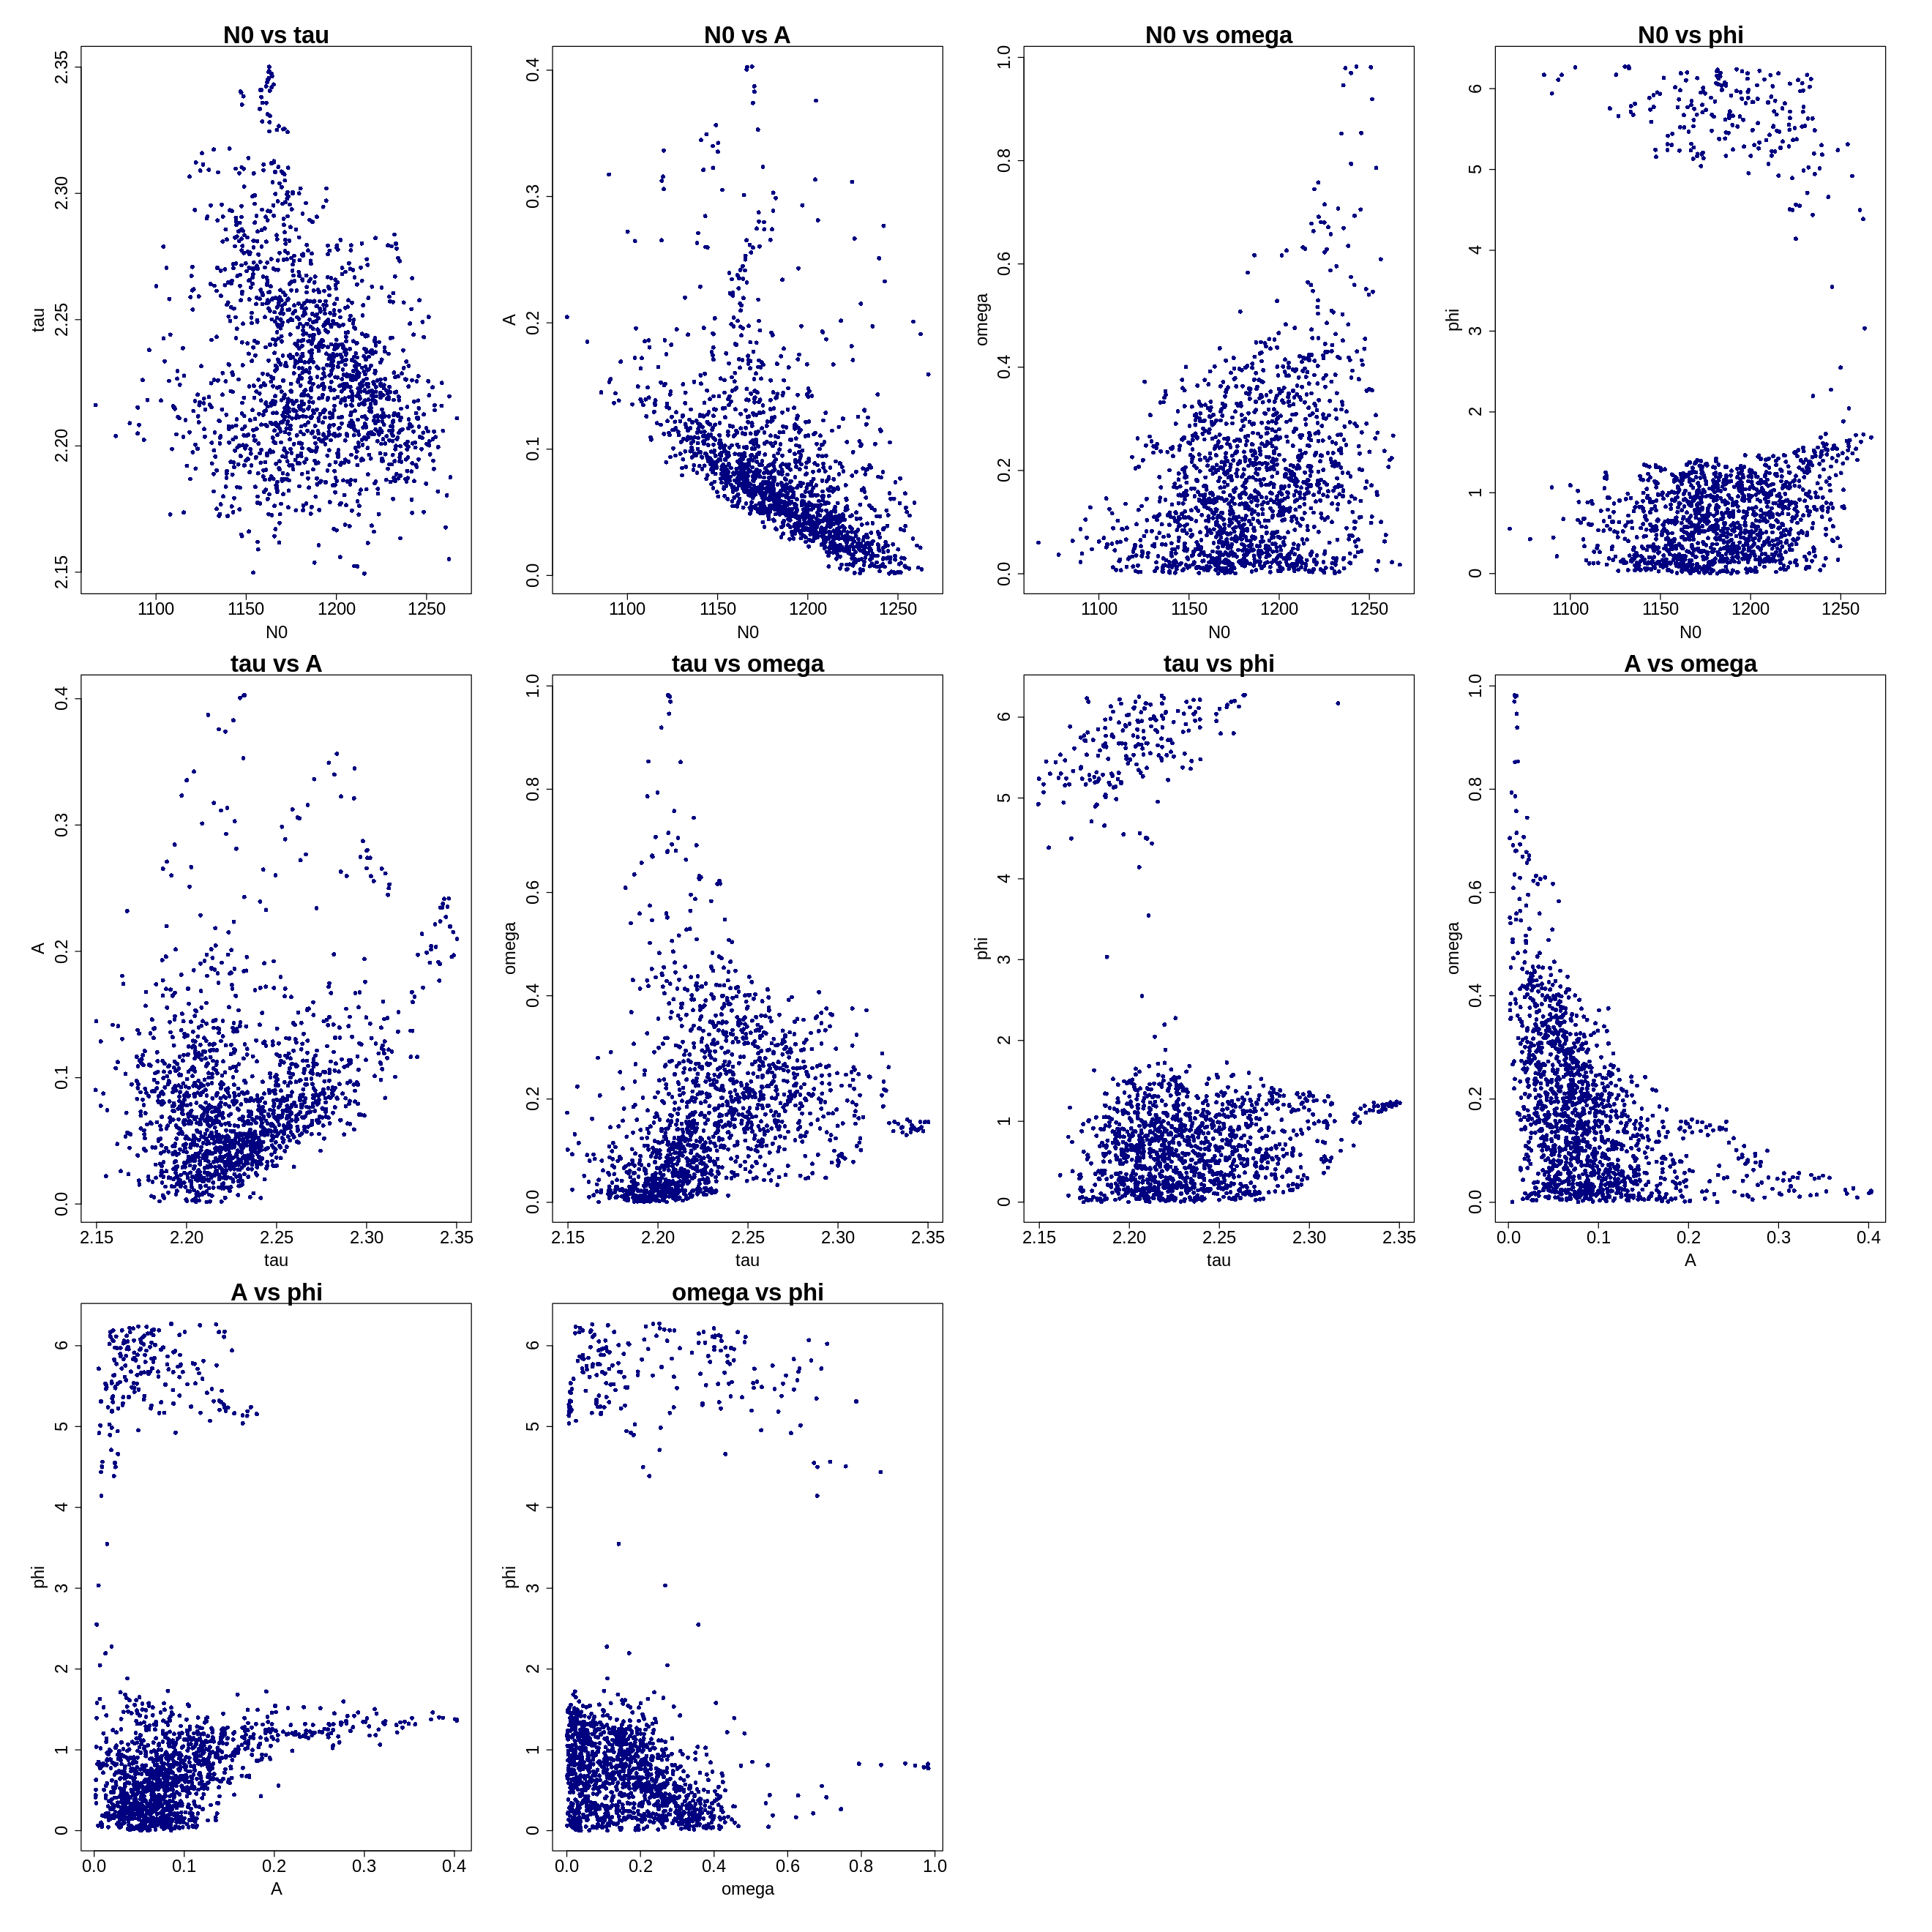

In [98]:
options(repr.plot.width = 22, repr.plot.height = 22)

params <- names(df)
pairs <- combn(params, 2, simplify = FALSE)

n <- length(pairs)
ncol <- ceiling(sqrt(n))
nrow <- ceiling(n / ncol)

layout(matrix(1:(nrow * ncol), nrow = nrow, byrow = TRUE), widths = rep(1.2, ncol), heights = rep(1.2, nrow))
par(mar = c(5, 5, 2, 2), oma = c(2, 2, 2, 2))

for (p in pairs) {
  plot(df[[p[1]]], df[[p[2]]],
       xlab = p[1], ylab = p[2],
       main = paste(p[1], "vs", p[2]),
       cex.main = 2.5, cex.axis = 1.8, cex.lab = 1.8,
       pch = 16, col = "navy")
}

# STUDIO FREQUENTISTA

BOH DA FARE, SECONDO ME FIGO E GARFA SI ESALTA CON IL CONFRONTO

# COSA DA FARE

FRANCESCO:

Controllare codice (tutto anche generazione dati) già fatto. UNITA' DI MISURAAAAAA (microsecondi e omega freq boh non so in che unità di misura).
Mostrare una volta i risultati delle varie catene (uno solo esemplificativo)

MOSTRI GRAFICO VARIE POSTERIORI DI UN PARAMETRO PER STAN: Rifare tutto con prior dei parametri diverse (uniformi, jeffrey(beta(0.5,0.5)) in un range oppure normali informate)

Da rifare tutto con jags

MARCO:

Presentazione slides di teoria con apparato e due formule

Calcolo probabilità che il segnale sia due muoni attaccati arrivasti dall'universo e non mu+ --> e+ appena decaduto (perché per noi i segnali sono mu+ e+, da indagare tempi tipici di questo decadimento rispetto a tempi tipici di arrivo di un un muone)... Poissiana

omega ----> gu ??? propagazione degli errori, male male in advance statistics

ALTRO:

Confronto, quindi histogrammi su stesso plot di colore di verso delle posterior di tau e omega-oppure gu- (con prior la stessa) di STAN, JAGS, FREQUENTISTA 